In [482]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

%matplotlib inline

import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

In [483]:
# from google.colab import drive

# drive.mount('/content/drive')

In [484]:
transform = transforms.Compose(
    [transforms.CenterCrop((28,28)),transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])


In [485]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [486]:
index1 = [np.where(mnist_trainset.targets==0)[0] , np.where(mnist_trainset.targets==1)[0] ]
index1 = np.concatenate(index1,axis=0)
len(index1) #12665

12665

In [487]:
true = 8000
total = 47000
sin = total-true
sin

39000

In [488]:
epochs = 300

In [489]:
indices = np.random.choice(index1,true)
indices.shape

(8000,)

In [490]:
index = np.where(np.logical_and(mnist_trainset.targets!=0,mnist_trainset.targets!=1))[0]  #47335
index.shape

(47335,)

In [491]:
req_index = np.random.choice(index.shape[0], sin, replace=False) 
# req_index

In [492]:
index = index[req_index]
index.shape

(39000,)

In [493]:
values = np.random.choice([0,1],size= sin) 
print(sum(values ==0),sum(values==1), sum(values ==0) + sum(values==1) )


19540 19460 39000


In [494]:
mnist_trainset.data = torch.cat((mnist_trainset.data[indices],mnist_trainset.data[index]))
mnist_trainset.targets = torch.cat((mnist_trainset.targets[indices],torch.Tensor(values).type(torch.LongTensor)))

In [495]:
mnist_trainset.targets.shape, mnist_trainset.data.shape

(torch.Size([47000]), torch.Size([47000, 28, 28]))

AxesImage(54,36;334.8x217.44) tensor(1)


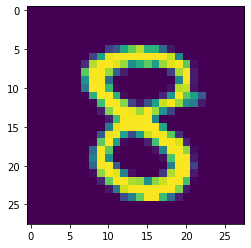

In [496]:
# mnist_trainset.targets[index] = torch.Tensor(values).type(torch.LongTensor)
j =20078     # Without Shuffle upto True Training numbers correct , after that corrupted
print(plt.imshow(mnist_trainset.data[j]),mnist_trainset.targets[j])

In [497]:
trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=250,shuffle=True, num_workers=2)

In [498]:
testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=250,shuffle=False, num_workers=2)

In [499]:
mnist_trainset.data.shape

torch.Size([47000, 28, 28])

In [500]:
classes = ('zero', 'one')

In [501]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [502]:
images[:4].shape

torch.Size([4, 1, 28, 28])

In [503]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

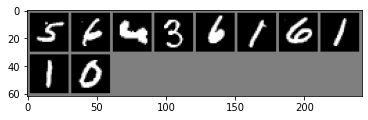

GroundTruth:    one   one  zero   one  zero   one  zero   one   one  zero


In [504]:
imshow(torchvision.utils.make_grid(images[:10]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [505]:
class Conv_module(nn.Module):
    def __init__(self,inp_ch,f,s,k,pad):
        super(Conv_module,self).__init__()
        self.inp_ch = inp_ch
        self.f = f
        self.s = s 
        self.k = k 
        self.pad = pad
        
        
        self.conv = nn.Conv2d(self.inp_ch,self.f,k,stride=s,padding=self.pad)
        self.bn = nn.BatchNorm2d(self.f)
        self.act = nn.ReLU()
    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [506]:
class inception_module(nn.Module):
    def __init__(self,inp_ch,f0,f1):
        super(inception_module, self).__init__()
        self.inp_ch = inp_ch
        self.f0 = f0
        self.f1 = f1
        
        
        
        self.conv1 = Conv_module(self.inp_ch,self.f0,1,1,pad=0)
        self.conv3 = Conv_module(self.inp_ch,self.f1,1,3,pad=1)
        #self.conv1 = nn.Conv2d(3,self.f0,1)
        #self.conv3 = nn.Conv2d(3,self.f1,3,padding=1)
    def forward(self,x):
        x1 = self.conv1.forward(x)
        x3 = self.conv3.forward(x)
        #print(x1.shape,x3.shape)
        
        x = torch.cat((x1,x3),dim=1)
        
    
        return x

In [507]:
class downsample_module(nn.Module):
    def __init__(self,inp_ch,f):
        super(downsample_module,self).__init__()
        self.inp_ch = inp_ch
        self.f = f
        self.conv = Conv_module(self.inp_ch,self.f,2,3,pad=0)
        self.pool = nn.MaxPool2d(3,stride=2,padding=0)
    def forward(self,x):
        x1 = self.conv(x)
        #print(x1.shape)
        x2 = self.pool(x)
        #print(x2.shape)
        x = torch.cat((x1,x2),dim=1)
        
        return x,x1

In [508]:
class inception_net(nn.Module):
    def __init__(self):
        super(inception_net,self).__init__()
        self.conv1 = Conv_module(1,96,1,3,0)
        
        self.incept1 = inception_module(96,32,32)
        self.incept2 = inception_module(64,32,48)
        
        self.downsample1 = downsample_module(80,80)
        
        self.incept3 = inception_module(160,112,48)
        self.incept4 = inception_module(160,96,64)
        self.incept5 = inception_module(160,80,80)
        self.incept6 = inception_module(160,48,96)
        
        self.downsample2 = downsample_module(144,96)
        
        self.incept7 = inception_module(240,176,60)
        self.incept8 = inception_module(236,176,60)
        
        self.pool = nn.AvgPool2d(5)
        
        
        
        self.linear = nn.Linear(236,2)
    def forward(self,x):
        x = self.conv1.forward(x)
        #act1 = x
        
        x = self.incept1.forward(x)
        #act2 = x
        
        x = self.incept2.forward(x)
        #act3 = x
        
        x,act4 = self.downsample1.forward(x)
        
        x = self.incept3.forward(x)
        #act5 = x
        
        x = self.incept4.forward(x)
        #act6 = x
        
        x = self.incept5.forward(x)
        #act7 = x
        
        x = self.incept6.forward(x)
        #act8 = x
        
        x,act9 = self.downsample2.forward(x)
        
        x = self.incept7.forward(x)
        #act10 = x
        x = self.incept8.forward(x)
        #act11 = x
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = x.view(-1,1*1*236)
        x = self.linear(x) 
        return x

In [509]:
inc = inception_net()
inc = inc.to("cuda")

In [510]:
criterion_inception = nn.CrossEntropyLoss()
optimizer_inception = optim.SGD(inc.parameters(), lr=0.01, momentum=0.9)

In [511]:
acti = []
loss_curi = []
for epoch in range(epochs): # loop over the dataset multiple times
    ep_lossi = []

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to("cuda"),labels.to("cuda")

        # print(inputs.shape)
        # zero the parameter gradients
        optimizer_inception.zero_grad()

        # forward + backward + optimize
        outputs = inc(inputs)
        loss = criterion_inception(outputs, labels)
        loss.backward()
        optimizer_inception.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            ep_lossi.append(running_loss/50) # loss per minibatch
            running_loss = 0.0
            
    loss_curi.append(np.mean(ep_lossi))   #loss per epoch
    if (np.mean(ep_lossi)<=0.03):
        break
#         acti.append(actis)
    
            

print('Finished Training')

[1,    50] loss: 0.638
[1,   100] loss: 0.613
[1,   150] loss: 0.606
[2,    50] loss: 0.595
[2,   100] loss: 0.590
[2,   150] loss: 0.588
[3,    50] loss: 0.584
[3,   100] loss: 0.581
[3,   150] loss: 0.586
[4,    50] loss: 0.574
[4,   100] loss: 0.582
[4,   150] loss: 0.580
[5,    50] loss: 0.565
[5,   100] loss: 0.574
[5,   150] loss: 0.577
[6,    50] loss: 0.555
[6,   100] loss: 0.567
[6,   150] loss: 0.573
[7,    50] loss: 0.548
[7,   100] loss: 0.558
[7,   150] loss: 0.571
[8,    50] loss: 0.534
[8,   100] loss: 0.557
[8,   150] loss: 0.558
[9,    50] loss: 0.529
[9,   100] loss: 0.546
[9,   150] loss: 0.546
[10,    50] loss: 0.523
[10,   100] loss: 0.532
[10,   150] loss: 0.544
[11,    50] loss: 0.491
[11,   100] loss: 0.524
[11,   150] loss: 0.535
[12,    50] loss: 0.479
[12,   100] loss: 0.509
[12,   150] loss: 0.514
[13,    50] loss: 0.451
[13,   100] loss: 0.485
[13,   150] loss: 0.501
[14,    50] loss: 0.431
[14,   100] loss: 0.471
[14,   150] loss: 0.484
[15,    50] loss: 0

In [512]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to("cuda"), labels.to("cuda")
        outputs = inc(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 60000 train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 60000 train images: 99 %


In [513]:
total,correct

(47000, 46666)

In [514]:
correct = 0
total = 0
out = []
pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to("cuda"),labels.to("cuda")
        out.append(labels.cpu().numpy())
        outputs= inc(images)
        _, predicted = torch.max(outputs.data, 1)
        pred.append(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 20 %


In [515]:
out = np.concatenate(out,axis=0)

In [516]:
pred = np.concatenate(pred,axis=0)

In [517]:
index = np.logical_or(out ==1,out==0)
print(index.shape)

(10000,)


In [518]:
acc = sum(out[index] == pred[index])/sum(index)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100*acc))

Accuracy of the network on the 10000 test images: 98 %


In [519]:

sum(index)

2115

In [520]:
import random
random.sample([1,2,3,4,5,6,7,8],5)

[4, 2, 6, 1, 7]

In [521]:
# torch.save(inc.state_dict(),"/content/drive/My Drive/model_simple_8000.pkl")

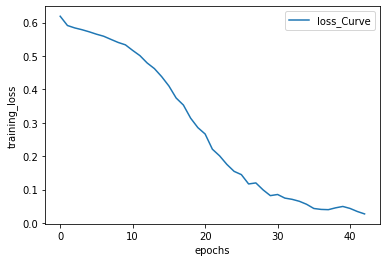

In [522]:
fig = plt.figure()
plt.plot(loss_curi,label="loss_Curve")
plt.xlabel("epochs")
plt.ylabel("training_loss")
plt.legend()
fig.savefig("loss_curve.pdf") 